## Introduction

<b>Source</b>
- https://www.kaggle.com/c/quora-question-pairs
- Applied AI Course


<b>Problem Statement</b>
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<b>Business Objectives</b>
- The cost of a mis-classification can be very high. (FP are more critical than FN)
- You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
- No strict latency concerns.
- Interpretability is partially important.

<b>Columns Description</b>
- id: normal index column of data
- qid1: ID for question 1
- qid2: ID for question 2
- question1: Actual text of question 1
- question2: Actual text of question 2
- is_duplicate: Label of whether two questions are duplicate or not. (0 = No, 1 = Yes)

## Imported Libraries

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Loading Data

In [27]:
data = pd.read_csv('data/train.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [28]:
print('Number of data points are : {}'.format(data.shape[0]))

Number of data points are : 404290


1. qid1 is ID for question 1
2. qid2 is ID for question 2
3. question1 and question2 columns are actual text
4. is_duplicatle is the label, whether the questions are duplicate or not (0 = not duplicate, 1 = duplicate)

## Exploratory Data Analysis

### General

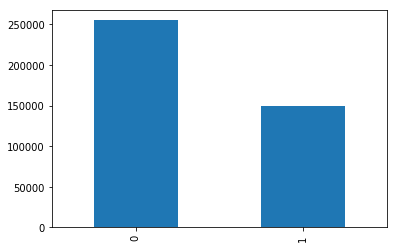

In [29]:
pd.value_counts(data['is_duplicate']).plot.bar()

In [30]:
data['is_duplicate'].value_counts(normalize=True)

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

In [31]:
data['is_duplicate'].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

Out of 404290 question pairs, 255027 Qpairs(\~63%) are not duplicate and 149263 Qpairs(~37%) are duplicate. <b> Slight imbalance in data </b>

In [32]:
allQIDs = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
num_unique_ques = len(np.unique(allQIDs))
print('Number of unique questions: {}'.format(num_unique_ques))

Number of unique questions: 537933


In [33]:
num_ques_repeat = np.sum(allQIDs.value_counts() > 1)
num_ques_once = np.sum(allQIDs.value_counts() == 1)

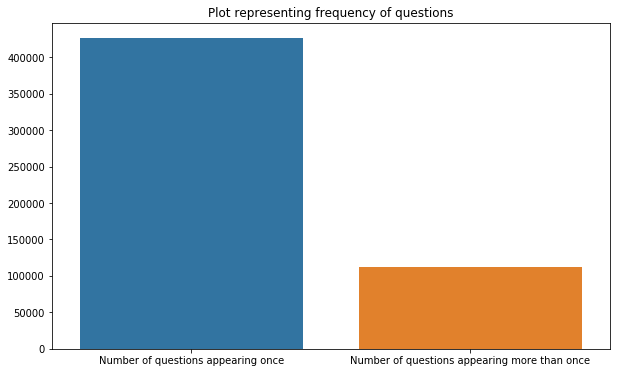

In [34]:
x = ["Number of questions appearing once" , "Number of questions appearing more than once"]
y =  [num_ques_once , num_ques_repeat]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing frequency of questions")
sns.barplot(x,y)
plt.show()

In [35]:
print('Number of questions appearing once: {}'.format(num_ques_once))
print('Number of questions appearing more than once: {}'.format(num_ques_repeat))

Number of questions appearing once: 426153
Number of questions appearing more than once: 111780


1. We have a total of 537933 different question IDs
2. Out of this, 426153 QIDs only appear once.
3. Remaining 111780 QIDs appear more than once.

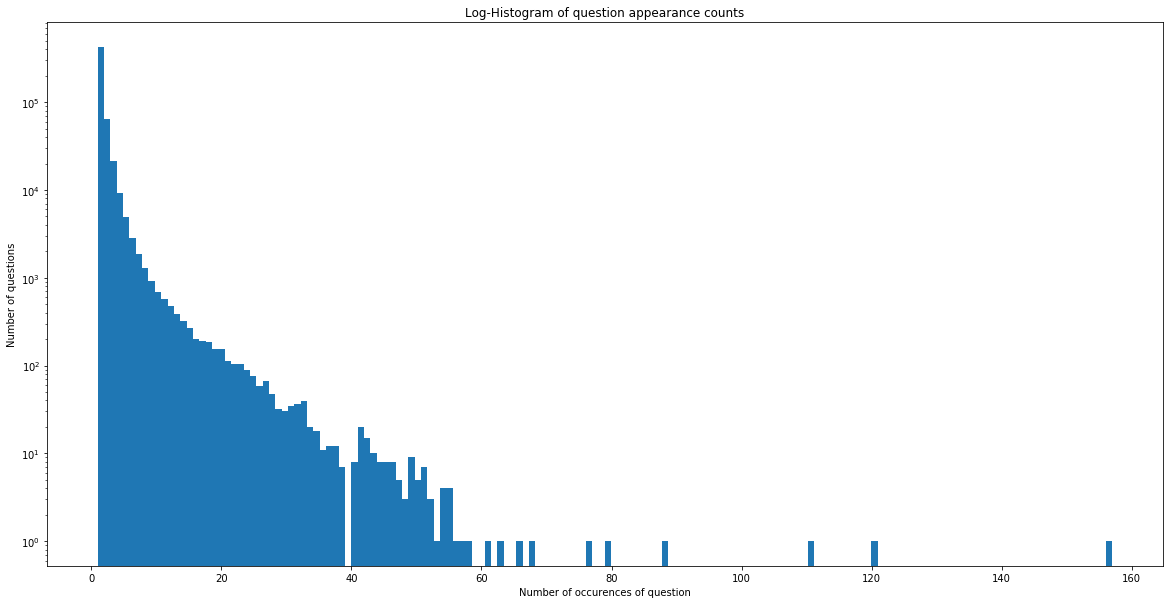

In [36]:
plt.figure(figsize=(20, 10))
plt.hist(allQIDs.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

In [37]:
print('Maximum number of times a single question is repeated: {}'.format(max(allQIDs.value_counts()))) 
print('QID appearing most number of times: {}'.format(allQIDs.value_counts().idxmax()))

Maximum number of times a single question is repeated: 157
QID appearing most number of times: 2559


1. Above histogram also shows us that most questions appear only once
2. One question appear 157 times with QID 2559

In [38]:
data[data['qid1'] == 2559]['question1'].iloc[:1]

14712    What are the best ways to lose weight?
Name: question1, dtype: object

The question that appears most in data is <b> What are the best ways to lose weight?</b>

### Missing Values / NULL Values Check

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<b>We have some missing values.</b> <br>
question1 has NULL for one row and question2 for two rows.

In [40]:
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


NaN values appear for QIDs 174364 and 493340. Let's find if we have question for these IDs in our data.

In [41]:
print(data[data['qid1'] == 174364]['question1'])
print(data[data['qid2'] == 174364]['question2'])

print(data[data['qid1'] == 493340]['question1'])
print(data[data['qid2'] == 493340]['question2'])

Series([], Name: question1, dtype: object)
105780    NaN
201841    NaN
Name: question2, dtype: object
363362    NaN
Name: question1, dtype: object
Series([], Name: question2, dtype: object)


As we cannot find any questions for these IDs, it's better to drop these rows.

In [42]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
id              404287 non-null int64
qid1            404287 non-null int64
qid2            404287 non-null int64
question1       404287 non-null object
question2       404287 non-null object
is_duplicate    404287 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


<b>We've dropped the rows with NaN values and now our data is free of NULL values</b>

### Checking for Duplicates

In [43]:
np.where(data['qid1'] == data['qid2'])

(array([], dtype=int64),)

Good! We don't have any row where qid1 and qid2 are same

In [44]:
data.drop_duplicates(subset={"qid1","qid2"}, keep='first', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
id              404287 non-null int64
qid1            404287 non-null int64
qid2            404287 non-null int64
question1       404287 non-null object
question2       404287 non-null object
is_duplicate    404287 non-null int64
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


<b> No duplicates found where two rows have same &lt;qid1, qid2&gt; pair </b>

## Feature Engineering

### Basic

- freq_qid1: Frequency of QId1. If qid1 = 3, freq_qid1 = how many types 3 occur as qid1
- freq_qid2: Frequency of QId2. If qid2 = 3, freq_qid2 = how many types 3 occur as qid2
- q1len: Length of question1
- q2len: Length of question2
- q1_words: Number of words in question1
- q2_words: Number of words in question2
- words_common: Number of unique common words in question1 and question2
- words_total: Total unique words in question1 and question2
- words_share: words_commmon / words_total
- freq_q1+q2: freq_qid1 + freq_qid2
- freq_q1-q2: |freq_qid1 - freq_qid2|

In [45]:
data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count')
data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
data['q1len'] = data['question1'].str.len() 
data['q2len'] = data['question2'].str.len()
data['q1_words'] = data['question1'].apply(lambda row: len(row.split(' ')))
data['q2_words'] = data['question2'].apply(lambda row: len(row.split(' ')))

def words_common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))    
    return 1.0 * len(w1 & w2)
data['words_common'] = data.apply(words_common, axis=1)

def words_total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))    
    return 1.0 * len(w1 | w2)
data['words_total'] = data.apply(words_total, axis=1)

def words_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(' ')))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(' ')))    
    return 1.0 * len(w1 & w2) / len(w1 | w2)
data['words_share'] = data.apply(words_share, axis=1)

data['freq_q1+q2'] = data['freq_qid1'] + data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1'] - data['freq_qid2'])

data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_words,q2_words,words_common,words_total,words_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,13.0,0.769231,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,16.0,0.250000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,20.0,0.200000,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,18.0,0.111111,4,2


In [46]:
data.describe()

,id,qid1,qid2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_words,q2_words,words_common,words_total,words_share,freq_q1+q2,freq_q1-q2
count,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000,404287.000000
mean,202144.340337,217243.151093,220955.212082,0.369201,2.827618,3.046972,59.536997,60.108507,10.944638,11.185146,4.511644,16.614544,0.325854,5.874589,1.845728
std,116708.673691,157751.614317,159903.168488,0.482589,4.487434,6.026892,29.940553,33.863588,5.431937,6.311040,3.098643,7.945330,0.235319,9.091099,5.187899
min,0.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,0.000000,2.000000,0.000000
25%,101071.500000,74436.500000,74726.500000,0.000000,1.000000,1.000000,39.000000,39.000000,7.000000,7.000000,2.000000,11.000000,0.142857,2.000000,0.000000
50%,202145.000000,192181.000000,197053.000000,0.000000,1.000000,1.000000,52.000000,51.000000,10.000000,10.000000,4.000000,15.000000,0.277778,3.000000,0.000000
75%,303216.500000,346573.000000,354692.000000,1.000000,3.000000,2.000000,72.000000,72.000000,13.000000,13.000000,6.000000,20.000000,0.466667,5.000000,2.000000
max,404289.000000,537932.000000,537933.000000,1.000000,50.000000,120.000000,623.000000,1169.000000,125.000000,237.000000,41.000000,154.000000,1.000000,157.000000,119.000000


1. Mimnimum length of questions in [question1]: 1
2. Mimnimum length of questions in [question2]: 1
3. Length of question1 ranges from 1 to 623. Question1 are as small as single character. Avg. length of question1 is ~60.
4. Length of question2 ranges from 1 to 1169. Question2 are as small as single character. Avg. length of question2 is ~60.
5. Average words in questions are ~11

In [47]:
print('Number of Questions with minimum length [question1]: {}'.format(data[data['q1len'] == min(data['q1len'])].shape[0]))
print('Number of Questions with minimum length [question2]: {}'.format(data[data['q2len'] == min(data['q2len'])].shape[0]))

Number of Questions with minimum length [question1]: 19
Number of Questions with minimum length [question2]: 2


<b> Analysis words_share </b>

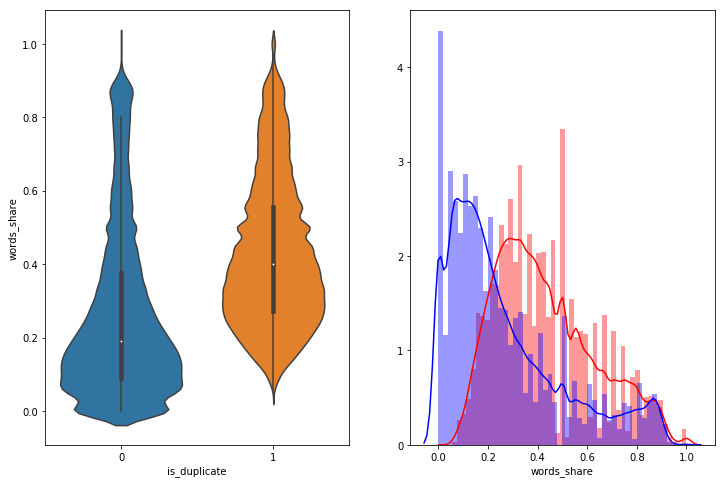

In [48]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'words_share', data = data)

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['words_share'], label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['words_share'], label = "0" , color = 'blue')

plt.show()

- There is partial overlap for this column between two classes
- <b> This feature can be useful </b>

<b> Analysis words_common </b>

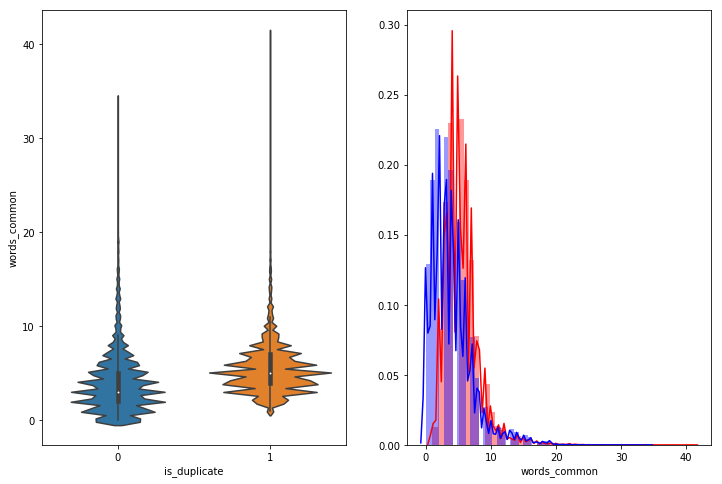

In [49]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'words_common', data = data)

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['words_common'], label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['words_common'], label = "0" , color = 'blue')

plt.show()

- This feature has heavy overlap for two classes.
- <b> Does not seems to be useful </b>
- Graph is mainly right tailed, most questions have commons words from range 0 - 20

<b> Analysis words_total </b>

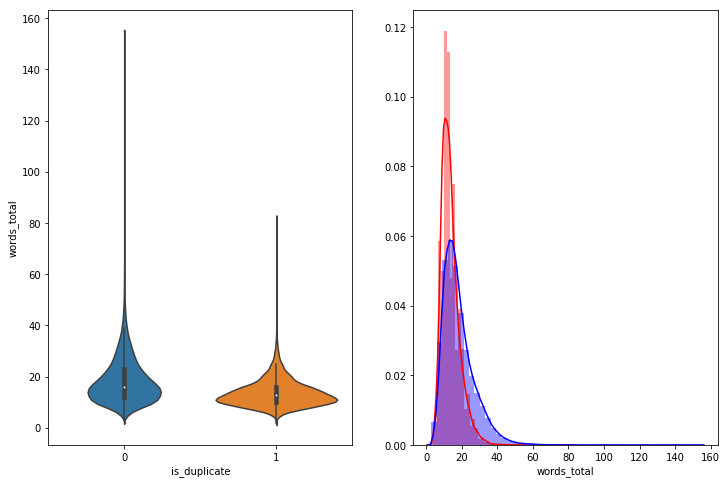

In [50]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'words_total', data = data)

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['words_total'], label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['words_total'], label = "0" , color = 'blue')

plt.show()

- This feature also seems to have heavy overlap.
- <b> Does not seems to be useful </b>
- This graph is also right skewed. Most sentences have total words in range 0 - 60.